In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from TOV_Solver import WaveNetTOV, evaluate_model
import matplotlib.pyplot as plt
import joblib
from TOV_Solver import tov_load_and_preprocess
from preprocessing import _resample_group


Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Train Loss: 0.000186 | Val Loss: 0.000187 | Val R²: 0.997314 | LR: 1.000000e-05
ckpt = torch.load("models/tov_solver.pt", map_location="cpu")

# 3️⃣ If it’s a dict:
model = WaveNetTOV()
model.load_state_dict(ckpt)
model.eval()

WaveNetTOV(
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (input_conv): CausalConv1d()
  (hidden_layers): ModuleList(
    (0-8): 9 x CausalConv1d()
  )
  (output_conv): CausalConv1d()
)

Input Data

In [4]:
df = pd.read_csv("data/sample_mr.csv")

# pick one ID/model pair
group = df[(df["ID"] == df["ID"].iloc[0]) & (df["model"] == df["model"].iloc[0])]

out = _resample_group(group, column="M", Np=32)
print(out)

         ID  model          R         M
0   18895.0  RMFNL  15.129396  0.219993
1   18895.0  RMFNL  14.394215  0.249460
2   18895.0  RMFNL  13.295986  0.322954
3   18895.0  RMFNL  12.928600  0.367667
4   18895.0  RMFNL  12.606342  0.473888
5   18895.0  RMFNL  12.458165  0.535335
6   18895.0  RMFNL  12.363150  0.673333
7   18895.0  RMFNL  12.374512  0.748744
8   18895.0  RMFNL  12.352720  0.908514
9   18895.0  RMFNL  12.376954  0.991033
10  18895.0  RMFNL  12.393166  1.156587
11  18895.0  RMFNL  12.382184  1.237796
12  18895.0  RMFNL  12.342156  1.393085
13  18895.0  RMFNL  12.326054  1.465869
14  18895.0  RMFNL  12.235813  1.599308
15  18895.0  RMFNL  12.179666  1.659336
16  18895.0  RMFNL  12.057593  1.765188
17  18895.0  RMFNL  11.981439  1.810938
18  18895.0  RMFNL  11.811921  1.888412
19  18895.0  RMFNL  11.720632  1.920417
20  18895.0  RMFNL  11.528790  1.971922
21  18895.0  RMFNL  11.429138  1.991873
22  18895.0  RMFNL  11.225156  2.021372
23  18895.0  RMFNL  11.121624  2.031412


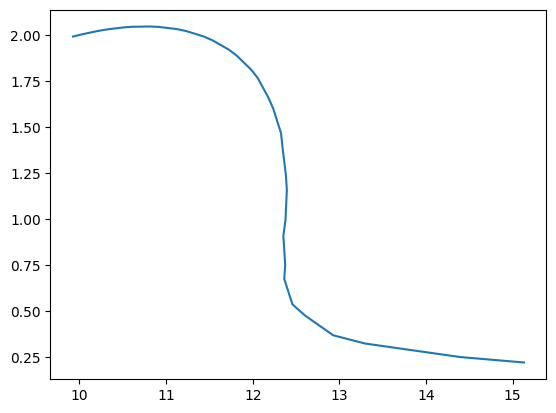

In [5]:
R = out["R"].to_numpy()
M = out["M"].to_numpy()

plt.plot(R, M)
plt.show()

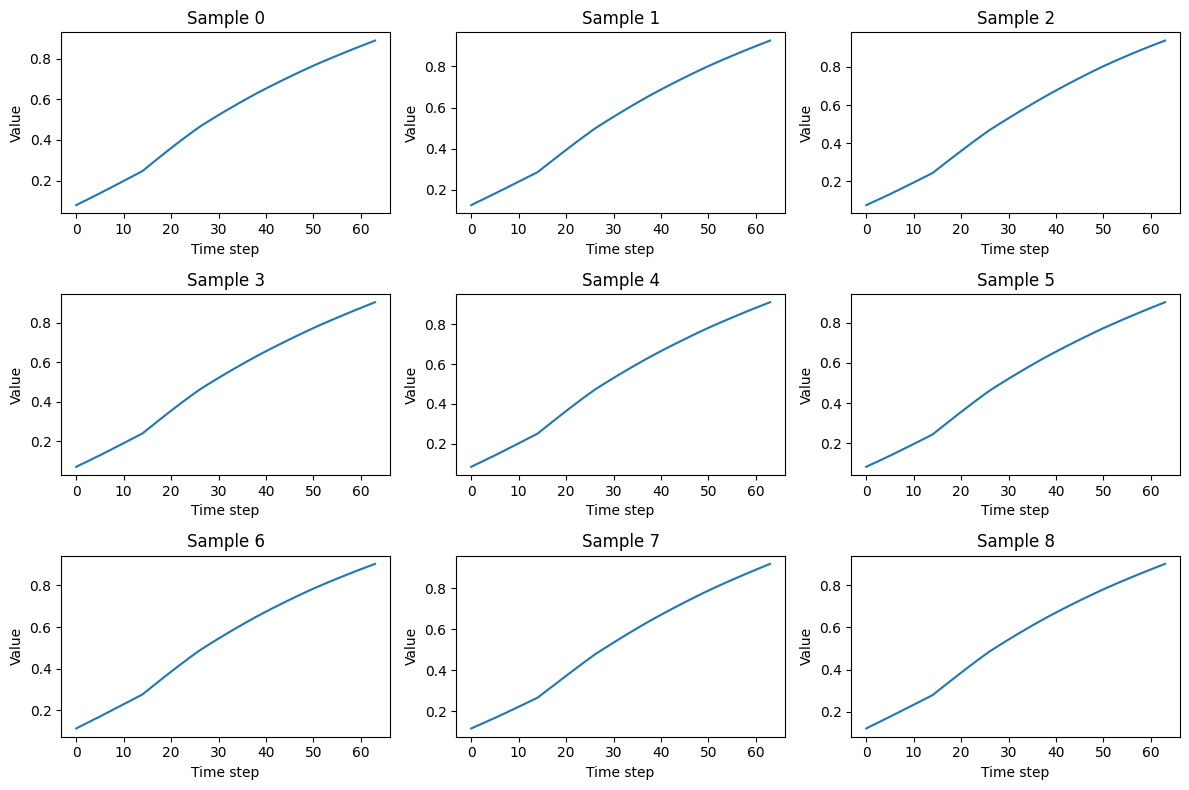

In [6]:
X_scaled = np.load("data/X_scaled.npy")
X_scaled.shape

# Plot first few samples
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for i in range(9):
    axes[i].plot(X_scaled[i, :, 1])  # Extract the feature dimension
    axes[i].set_title(f'Sample {i}')
    axes[i].set_xlabel('Time step')
    axes[i].set_ylabel('Value')
    
plt.tight_layout()

In [7]:
X_scaled[:,:, 1].max()

np.float32(1.0)

In [8]:
X_scaled[:,:, 1]

array([[0.07890793, 0.09106427, 0.1022849 , ..., 0.8704868 , 0.8794954 ,
        0.88841164],
       [0.12604049, 0.13785598, 0.1487856 , ..., 0.9076317 , 0.9166324 ,
        0.92553306],
       [0.07474998, 0.08665896, 0.09766854, ..., 0.91925263, 0.92884403,
        0.93829644],
       ...,
       [0.08368195, 0.0955226 , 0.10647377, ..., 0.9296823 , 0.94031566,
        0.95085436],
       [0.0566671 , 0.07030081, 0.08276831, ..., 0.93032396, 0.9409976 ,
        0.9515814 ],
       [0.08677316, 0.09858441, 0.10951041, ..., 0.9290197 , 0.9392752 ,
        0.94942415]], shape=(20000, 64), dtype=float32)

In [9]:
X_scaled[:,:, 1].min()

np.float32(0.017266154)

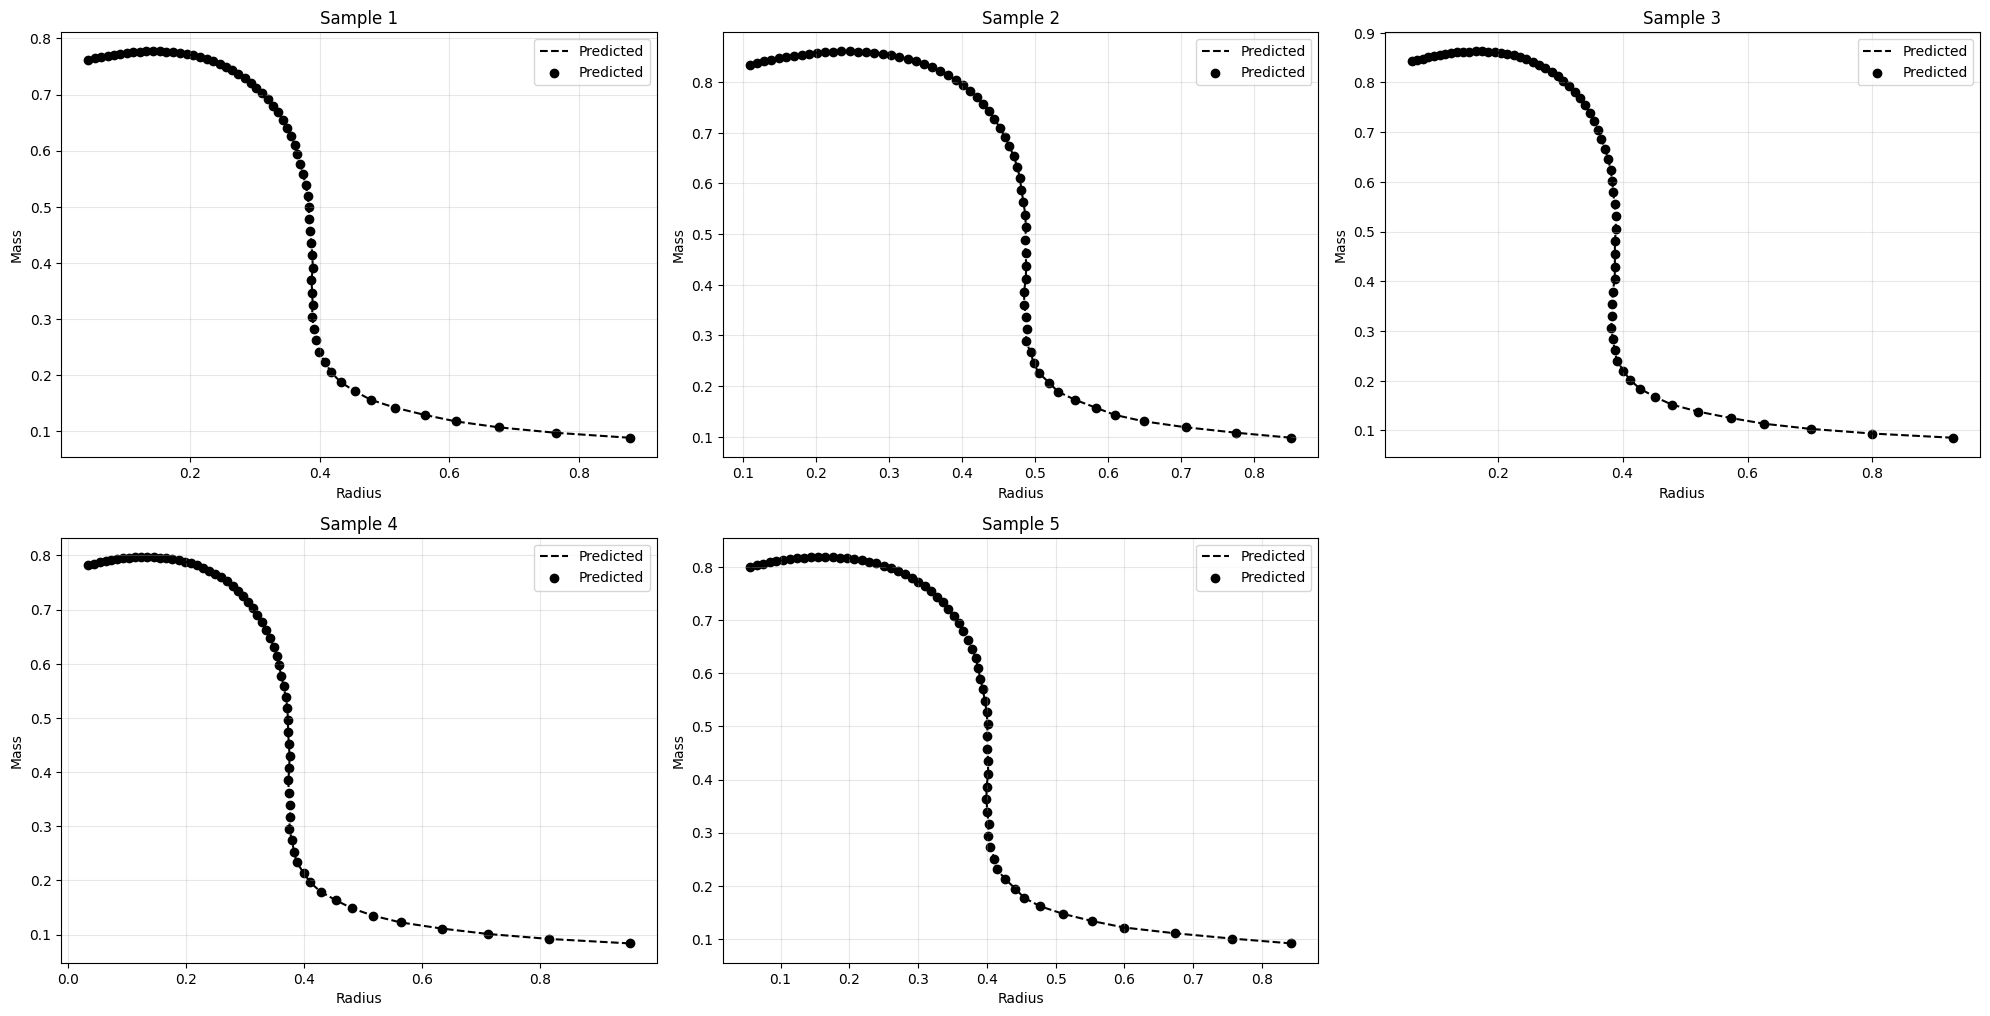

In [10]:
Y_scaled = np.load("data/Y_scaled.npy")

mass_pred_unscaled = Y_scaled[:, :, 0] 
radius_pred_unscaled = Y_scaled[:, :, 1] 

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(5):
    ax = axes[sample_idx]

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='black', label='Predicted')
    ax.scatter(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx], color='black', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(5, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Results

In [11]:
metrics, preds = evaluate_model(model, np.load("data/X_test.npy"), np.load("data/y_test.npy"))
metrics

# calculate the error on Mass and the radius separately

{'MSE': 0.00022408746008295566, 'R2': 0.9966844916343689}

In [12]:
np.load("data/y_test.npy").shape

(800, 64, 2)

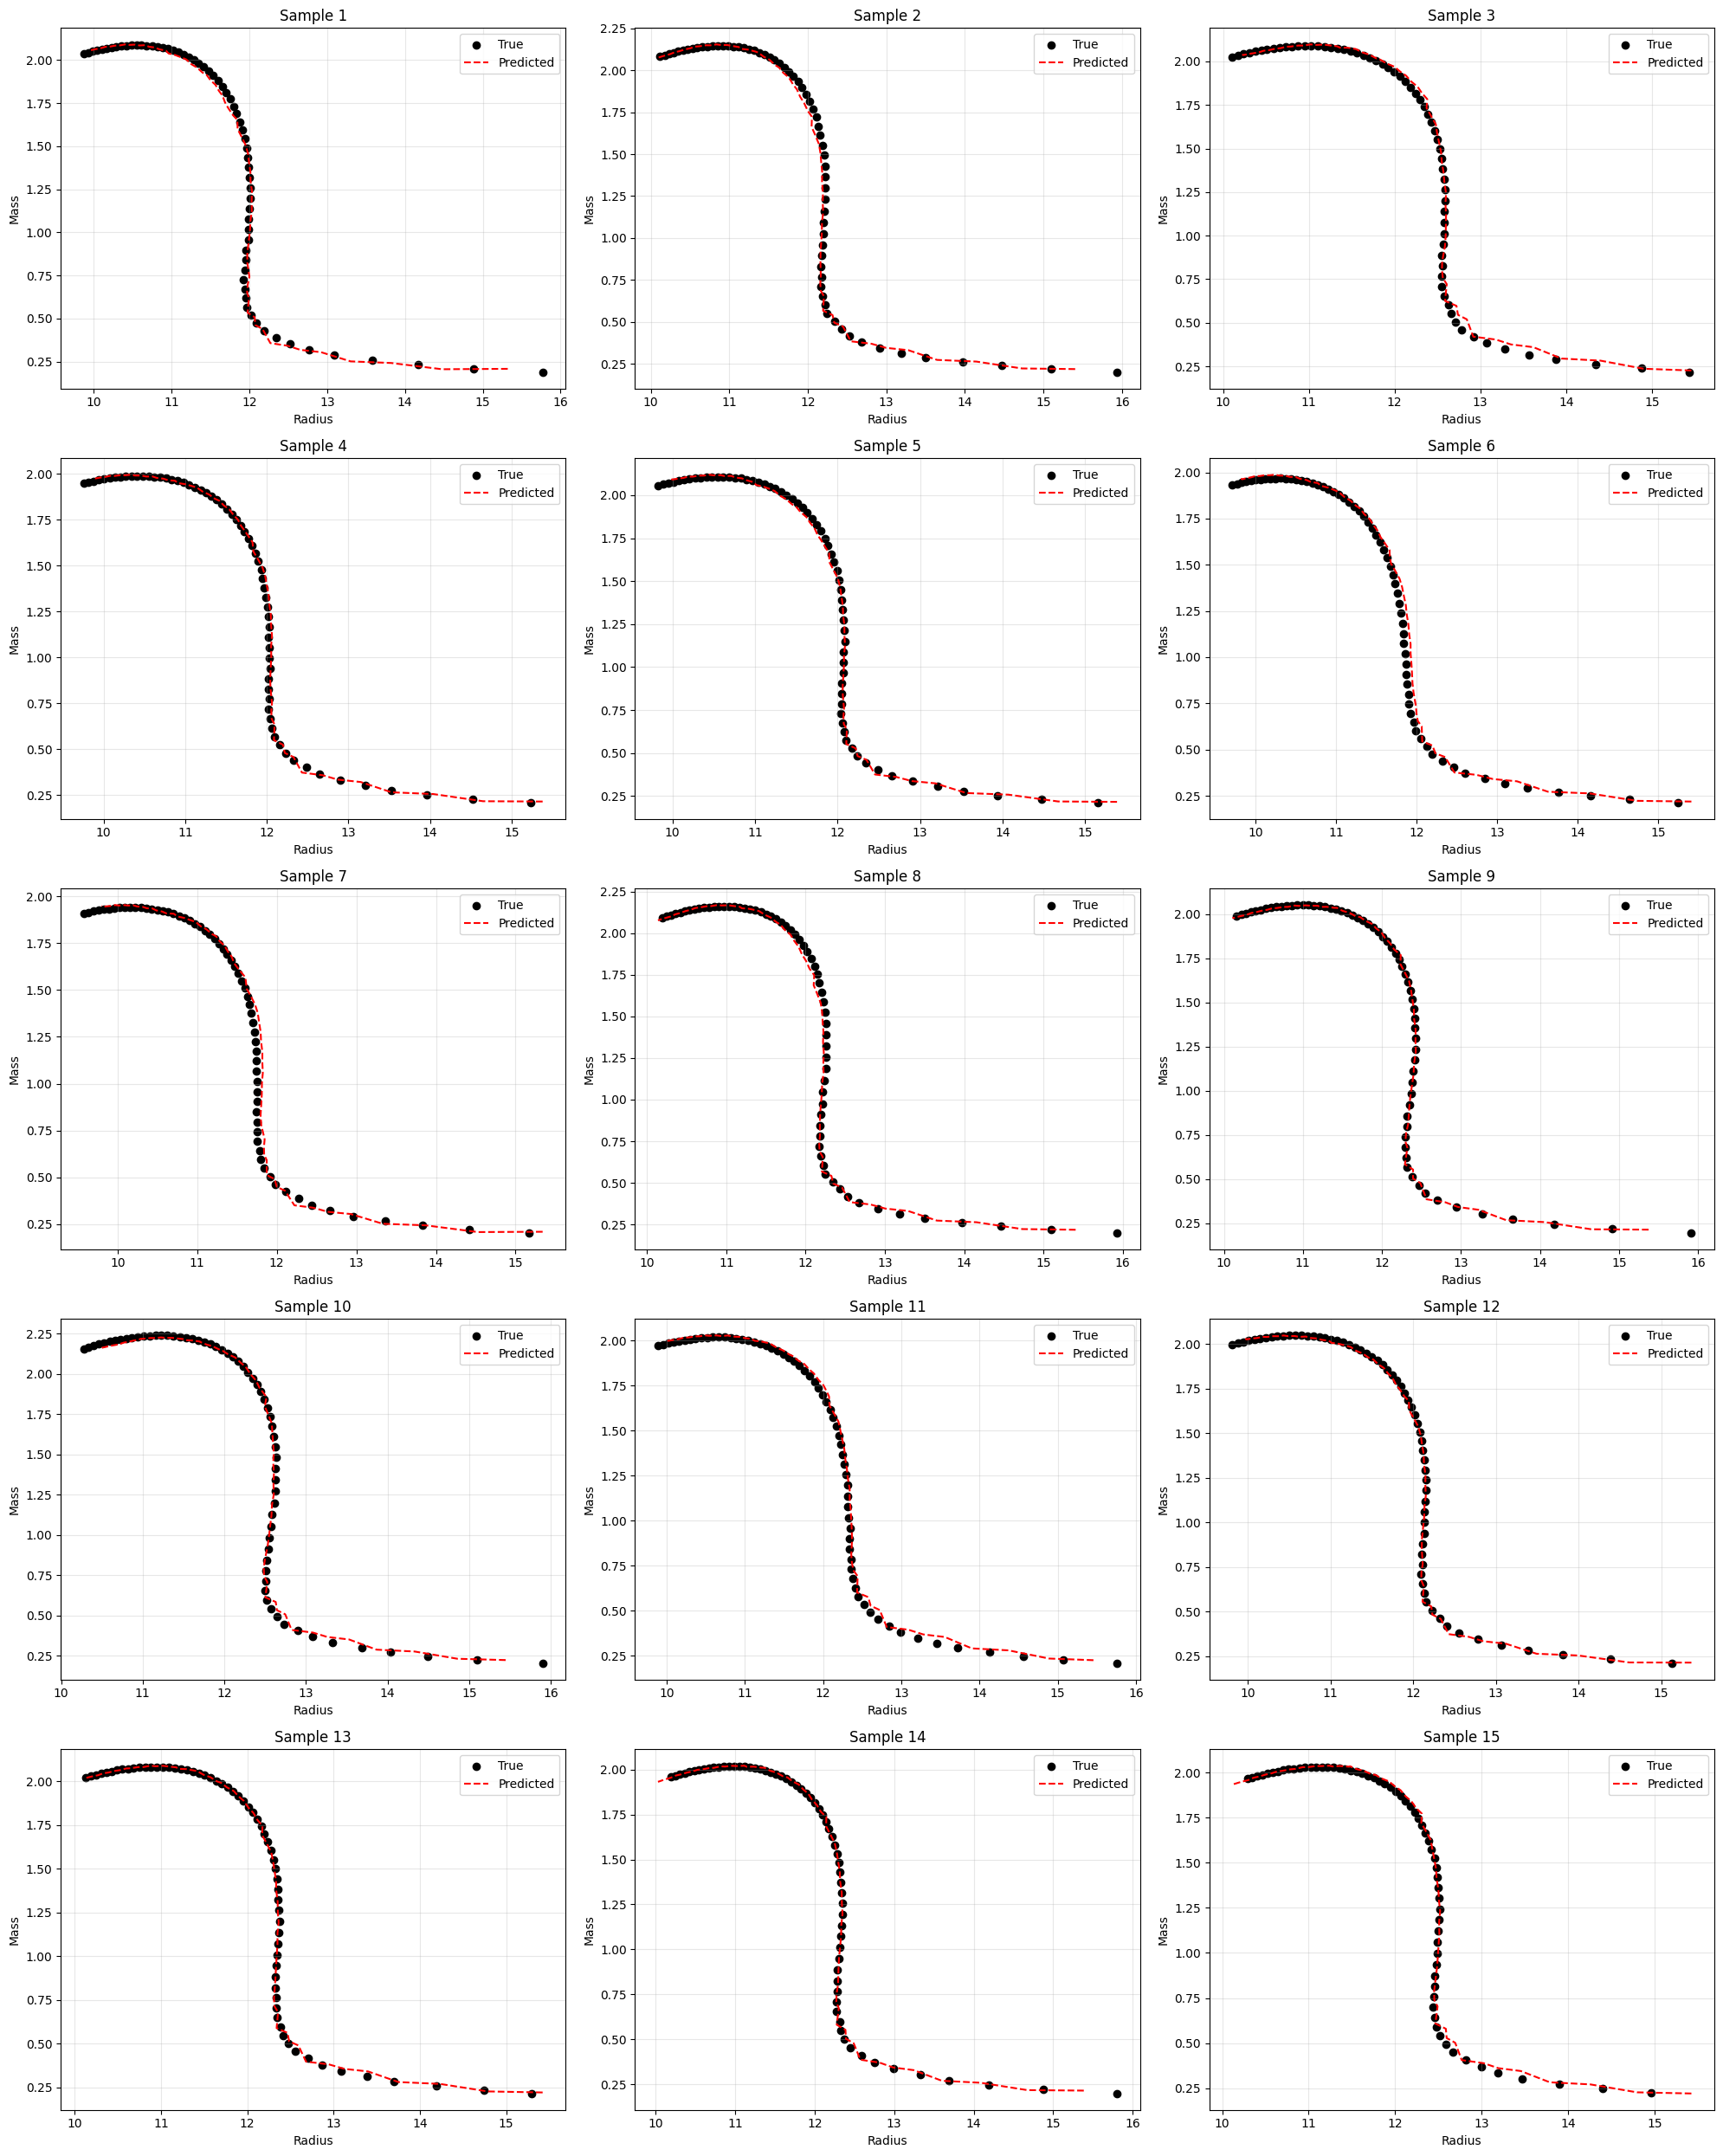

In [13]:
observed_mr = pd.read_csv("data/sample_mr.csv")
M_MAX = observed_mr.query("ID != 19248")["M"].max()
R_MAX = 16.0
R_MIN = observed_mr.query("ID != 19248")["R"].min()

y_test = np.load("data/y_test.npy")
mass_pred_unscaled = preds[:, :, 0] * M_MAX
radius_pred_unscaled = preds[:, :, 1] * (R_MAX - R_MIN) + R_MIN
# Inverse-transform true values
mass_true_unscaled = y_test[:, :, 0] * M_MAX
radius_true_unscaled = y_test[:, :, 1] * (R_MAX - R_MIN) + R_MIN

# Plot results
fig, axes = plt.subplots(5, 3, figsize=(20, 25))
axes = axes.flatten()

for sample_idx in range(15):
    ax = axes[sample_idx]

    # True M-R relation (black)
    ax.scatter(radius_true_unscaled[sample_idx], mass_true_unscaled[sample_idx],
               color='black', label='True')

    # Predicted M-R relation (red dashed line)
    ax.plot(radius_pred_unscaled[sample_idx], mass_pred_unscaled[sample_idx],
            "--", color='red', label='Predicted')

    ax.set_title(f'Sample {sample_idx + 1}')
    ax.set_xlabel('Radius')
    ax.set_ylabel('Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(15, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()